In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Load the dataset
file_path = 'merged_data.csv'
data = pd.read_csv(file_path)


In [12]:
# Step 1: Data Aggregation - Create customer-level features
customer_data = data.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Number of transactions
    'TotalValue': 'sum',       # Total spending
    'Quantity': 'mean',        # Average quantity per transaction
}).rename(columns={
    'TransactionID': 'TransactionCount',
    'TotalValue': 'TotalSpending',
    'Quantity': 'AvgQuantity'
}).reset_index()


In [13]:
# Step 2: Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customer_data[['TransactionCount', 'TotalSpending', 'AvgQuantity']])


In [14]:
# Step 3: Perform clustering and evaluate with DB Index
def perform_clustering(data):
    db_indices = []
    clusters_range = range(2, 11)
    models = []
    for k in clusters_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        db_index = davies_bouldin_score(data, labels)
        db_indices.append(db_index)
        models.append((k, labels, kmeans))
    return clusters_range, db_indices, models


In [15]:
# Run clustering
clusters_range, db_indices, clustering_models = perform_clustering(normalized_data)


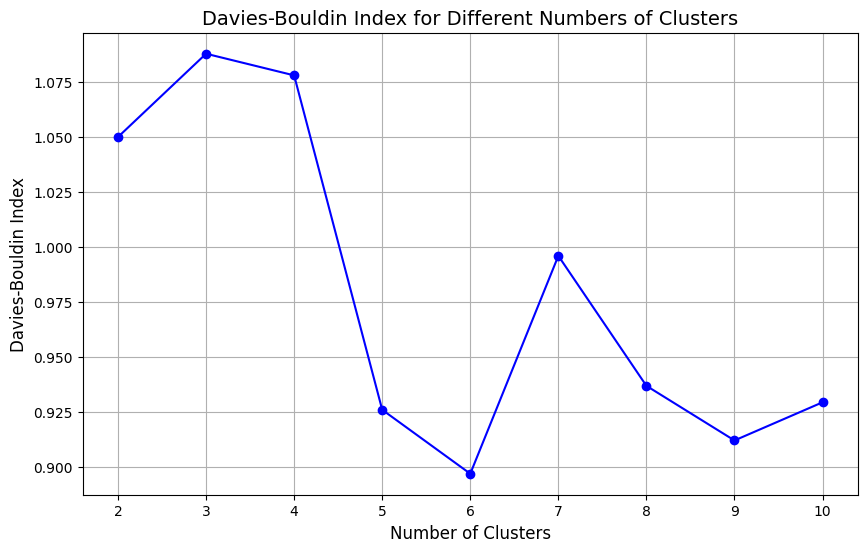

[1.050059489973886, 1.0879214058512618, 1.078073266139119, 0.9260461427398946, 0.8969844738833146, 0.9960327374623829, 0.9369396372237095, 0.9121090958523871, 0.9294569841057033]


In [27]:
# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, db_indices, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Davies-Bouldin Index', fontsize=12)
plt.grid()
plt.show()

In [17]:
# Identify optimal number of clusters
optimal_clusters = clusters_range[db_indices.index(min(db_indices))]
print(f"The optimal number of clusters is: {optimal_clusters}")

# Step 4: Visualize the clusters
# Use the optimal number of clusters to label the data
optimal_model = [model for k, labels, model in clustering_models if k == optimal_clusters][0]
customer_data['Cluster'] = optimal_model.labels_


The optimal number of clusters is: 6


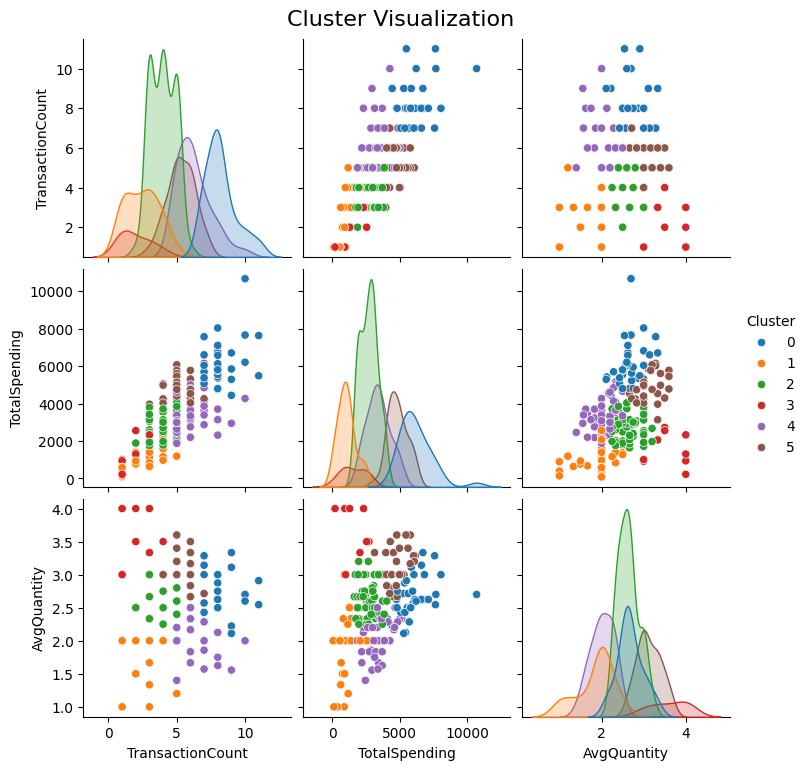

In [24]:
# Pairplot for visualization of clusters
sns.pairplot(customer_data, vars=['TransactionCount', 'TotalSpending', 'AvgQuantity'], hue='Cluster', palette='tab10')
plt.suptitle("Cluster Visualization", y=1.02, fontsize=16)
plt.show()


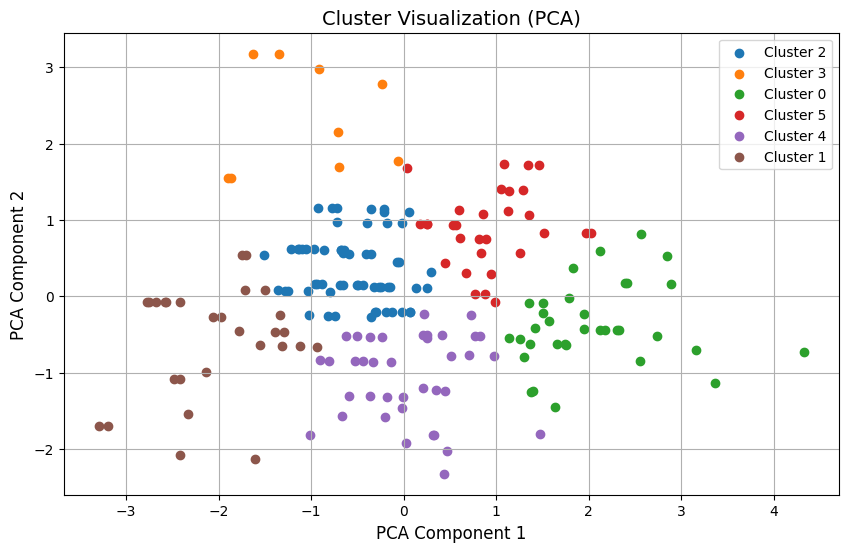

In [26]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

# Add PCA components to the customer data
customer_data['PCA1'] = pca_data[:, 0]
customer_data['PCA2'] = pca_data[:, 1]

# Scatter plot for clusters
plt.figure(figsize=(10, 6))
for cluster in customer_data['Cluster'].unique():
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
plt.title('Cluster Visualization (PCA)', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend()
plt.grid()

In [32]:
print(f"DB Index Score:{db_indices[4]}")

DB Index Score:0.8969844738833146


In [29]:

silhouette_avg = silhouette_score(normalized_data, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.32690076560631864


In [41]:
# Add cluster labels to the normalized data for grouping
customer_data['Cluster'] = optimal_model.labels_
cd=customer_data.drop('CustomerID',axis=1)

# Calculate the mean of each feature for each cluster
cluster_characteristics = cd.groupby('Cluster').mean()
print("Cluster Characteristics:")
print(cluster_characteristics)


Cluster Characteristics:
         TransactionCount  TotalSpending  AvgQuantity      PCA1      PCA2
Cluster                                                                  
0                8.205882    6173.227941     2.678052  2.052709 -0.385773
1                2.464286    1066.381786     1.861310 -2.038011 -0.583164
2                3.966667    2703.006333     2.627778 -0.551269  0.364385
3                2.000000    1563.816667     3.592593 -1.040491  2.314660
4                6.236842    3406.302632     2.018567  0.052744 -1.059856
5                5.300000    4818.429667     3.125079  0.923617  0.900812
